In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.metrics import accuracy_score

from google.colab import drive
if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
INPUT_PATH = "/content/drive/MyDrive/GCI/titanic/Input"

train = pd.read_csv(os.path.join(INPUT_PATH, "train.csv"))
test = pd.read_csv(os.path.join(INPUT_PATH, "test.csv"))
train["Perished"] = train["Perished"].replace({1:0, 0:1})

data = pd.concat([train, test], ignore_index = True)

# WCG Model

In [3]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

data['Ticket_id'] = 'new_col'
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')

data['Group_id'] = 'new_col2'
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

In [4]:
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'
data.loc[data["Title"] == 'man', 'Group_id'] = 'noGroup'
data['WC_count'] = data.loc[data["Title"] != 'man'].groupby('Group_id')['Group_id'].transform('count')
data.loc[data["WC_count"] <=1, 'Group_id'] = 'noGroup'

In [5]:
cols = ['PassengerId', 'Perished', 'Name', 'Title', 'Ticket_id','Group_id', 'Fare']
data.loc[(data.Ticket_id == '1-1696-134.5-C') & (data.Title != 'man'), cols]

PassengerId  Perished  \
319           320       1.0   
337           338       1.0   
1087         1088       NaN   
1262         1263       NaN   

                                                   Name  Title  \
319   Spedden, Mrs. Frederic Oakley (Margaretta Corn...  woman   
337                     Burns, Miss. Elizabeth Margaret  woman   
1087                    Spedden, Master. Robert Douglas    boy   
1262                          Wilson, Miss. Helen Alice  woman   

           Ticket_id                Group_id   Fare  
319   1-1696-134.5-C  Spedden-1-1696-134.5-C  134.5  
337   1-1696-134.5-C                 noGroup  134.5  
1087  1-1696-134.5-C  Spedden-1-1696-134.5-C  134.5  
1262  1-1696-134.5-C                 noGroup  134.5

In [6]:
indices = []
count = 0
for i in range(len(data)):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

11 passengers were added to an existing group


In [7]:
cols = ['PassengerId', 'Perished', 'Name', 'Title', 'Group_id', 'Fare']
data.loc[indices, cols]

PassengerId  Perished                                          Name  \
337           338       1.0               Burns, Miss. Elizabeth Margaret   
708           709       1.0                          Cleaver, Miss. Alice   
950           951       NaN                   Chaudanson, Miss. Victorine   
1032         1033       NaN                          Daniels, Miss. Sarah   
1067         1068       NaN                          Sincock, Miss. Maude   
1140         1141       NaN     Khalil, Mrs. Betros (Zahie Maria" Elias)"   
1171         1172       NaN                        Oreskovic, Miss. Jelka   
1258         1259       NaN  Riihivouri, Miss. Susanna Juhantytar Sanni""   
1262         1263       NaN                     Wilson, Miss. Helen Alice   
1266         1267       NaN                      Bowen, Miss. Grace Scott   
1291         1292       NaN                       Bonnell, Miss. Caroline   

      Title                     Group_id      Fare  
337   woman       Spedden-1-1696-134.5-C  134.5000  
708   woman     Allison-1-11378-151.55-S  151.5500  
950   woman  Ryerson-1-PC 1760-262.375-C  262.3750  
1032  woman     Allison-1-11378-151.55-S  151.5500  
1067  woman   Davies-2-C.A. 3311-36.75-S   36.7500  
1140  woman       Zabour-3-266-14.4542-C   14.4542  
1171  woman       Cacic-3-31508-8.6625-S    8.6625  
1258  woman    Panula-3-310129-39.6875-S   39.6875  
1262  woman       Spedden-1-1696-134.5-C  134.5000  
1266  woman  Ryerson-1-PC 1760-262.375-C  262.3750  
1291  woman       Wick-1-3692-164.8667-S  164.8667

In [8]:
number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

Number of groups found: 80

Number of passengers in a group: 230

Composition of the groups:
woman    171
boy       59


In [9]:
data['WCSurvived'] = data.loc[(data["Title"] != 'man') & (data["Group_id"] != 'noGroup')].groupby('Group_id').Perished.transform('mean')

In [10]:
cols = ['PassengerId', 'Perished', 'WCSurvived', 'Name', 'Title', 'Group_id', 'Fare']
data.loc[data["Group_id"] == 'Sage-3-CA. 234-69.55-S', cols]

PassengerId  Perished  WCSurvived                               Name  \
159           160       0.0         0.0         Sage, Master. Thomas Henry   
180           181       0.0         0.0       Sage, Miss. Constance Gladys   
792           793       0.0         0.0            Sage, Miss. Stella Anna   
863           864       0.0         0.0  Sage, Miss. Dorothy Edith "Dolly"   
1079         1080       NaN         0.0                    Sage, Miss. Ada   
1251         1252       NaN         0.0        Sage, Master. William Henry   
1256         1257       NaN         0.0     Sage, Mrs. John (Annie Bullen)   

      Title                Group_id   Fare  
159     boy  Sage-3-CA. 234-69.55-S  69.55  
180   woman  Sage-3-CA. 234-69.55-S  69.55  
792   woman  Sage-3-CA. 234-69.55-S  69.55  
863   woman  Sage-3-CA. 234-69.55-S  69.55  
1079  woman  Sage-3-CA. 234-69.55-S  69.55  
1251    boy  Sage-3-CA. 234-69.55-S  69.55  
1256  woman  Sage-3-CA. 234-69.55-S  69.55

WCSurvived all data values:
1.00    134
0.00     76
0.75      6
0.50      5


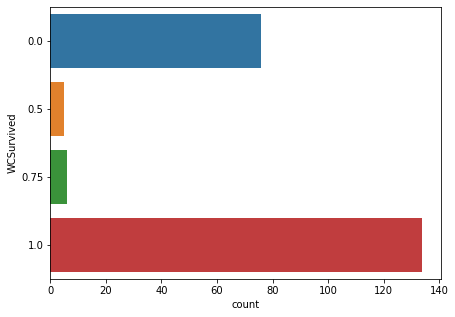

In [11]:
print('WCSurvived all data values:')
print(data["WCSurvived"].value_counts().to_string())
plt.figure(figsize=(7,5))
f = sns.countplot(y=data.WCSurvived)

In [12]:
data.loc[(data["WCSurvived"]==0.75) | (data["WCSurvived"]==0.5), cols].sort_values(by='Group_id')

PassengerId  Perished  WCSurvived  \
297           298       0.0        0.50   
305           306       1.0        0.50   
498           499       0.0        0.50   
708           709       1.0        0.50   
1032         1033       NaN        0.50   
25             26       1.0        0.75   
182           183       0.0        0.75   
233           234       1.0        0.75   
261           262       1.0        0.75   
1045         1046       NaN        0.75   
1270         1271       NaN        0.75   

                                                   Name  Title  \
297                        Allison, Miss. Helen Loraine  woman   
305                      Allison, Master. Hudson Trevor    boy   
498     Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  woman   
708                                Cleaver, Miss. Alice  woman   
1032                               Daniels, Miss. Sarah  woman   
25    Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  woman   
182               Asplund, Master. Clarence Gustaf Hugo    boy   
233                      Asplund, Miss. Lillian Gertrud  woman   
261                   Asplund, Master. Edvin Rojj Felix    boy   
1045                       Asplund, Master. Filip Oscar    boy   
1270                        Asplund, Master. Carl Edgar    boy   

                       Group_id      Fare  
297    Allison-1-11378-151.55-S  151.5500  
305    Allison-1-11378-151.55-S  151.5500  
498    Allison-1-11378-151.55-S  151.5500  
708    Allison-1-11378-151.55-S  151.5500  
1032   Allison-1-11378-151.55-S  151.5500  
25    Asplund-3-34707-31.3875-S   31.3875  
182   Asplund-3-34707-31.3875-S   31.3875  
233   Asplund-3-34707-31.3875-S   31.3875  
261   Asplund-3-34707-31.3875-S   31.3875  
1045  Asplund-3-34707-31.3875-S   31.3875  
1270  Asplund-3-34707-31.3875-S   31.3875

In [13]:
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), cols].sort_values(by='Group_id')

PassengerId  Perished  WCSurvived  \
1259         1260       NaN         NaN   
1293         1294       NaN         NaN   
1044         1045       NaN         NaN   
1154         1155       NaN         NaN   
1050         1051       NaN         NaN   
1172         1173       NaN         NaN   
1300         1301       NaN         NaN   
1083         1084       NaN         NaN   
1235         1236       NaN         NaN   

                                                Name  Title  \
1259         Gibson, Mrs. Leonard (Pauline C Boeson)  woman   
1293                  Gibson, Miss. Dorothy Winifred  woman   
1044  Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)  woman   
1154                    Klasen, Miss. Gertrud Emilia  woman   
1050             Peacock, Mrs. Benjamin (Edith Nile)  woman   
1172                  Peacock, Master. Alfred Edward    boy   
1300                       Peacock, Miss. Treasteall  woman   
1083               van Billiard, Master. Walter John    boy   
1235             van Billiard, Master. James William    boy   

                                  Group_id     Fare  
1259                 Gibson-1-11237-59.4-C  59.4000  
1293                 Gibson-1-11237-59.4-C  59.4000  
1044              Klasen-3-35040-12.1833-S  12.1833  
1154              Klasen-3-35040-12.1833-S  12.1833  
1050  Peacock-3-SOTON/O.Q. 310131-13.775-S  13.7750  
1172  Peacock-3-SOTON/O.Q. 310131-13.775-S  13.7750  
1300  Peacock-3-SOTON/O.Q. 310131-13.775-S  13.7750  
1083         van Billiard-3-A/5. 85-14.5-S  14.5000  
1235         van Billiard-3-A/5. 85-14.5-S  14.5000

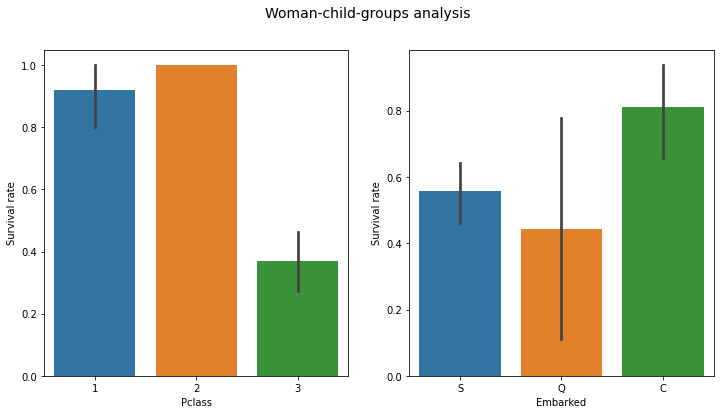

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Woman-child-groups analysis', fontsize=14)
a = sns.barplot(x='Pclass', y='Perished', data=data[data.Group_id != 'noGroup'], ax=ax[0]).set_ylabel('Survival rate')
b = sns.barplot(x='Embarked', y='Perished', data=data[data.Group_id != 'noGroup'], ax=ax[1]).set_ylabel('Survival rate')

In [15]:
# plcass = 1,2 -> 0
# pclass = 3   -> 1
data.loc[data["Group_id"].isin(test_groups), 'WCSurvived'] = 0
data.loc[(data["Group_id"].isin(test_groups)) & (data["Pclass"] != 3), 'WCSurvived'] = 1

In [16]:
data.loc[len(train):, 'Predict'] = 0
data.loc[len(train):, 'Predict'][data["Sex"] == 'female'] = 1

# WCSurvived = 0 の時、死亡
data.loc[len(train):,'Predict'][(data["Sex"] == 'female') & (data['WCSurvived'] == 0)] = 0
# WCSurvived = 1 の時、生存
data.loc[len(train):, 'Predict'][(data["Title"] == 'boy') & (data['WCSurvived'] == 1)] = 1

# 0.75の場合は生存1にしても変化なし
# 0.50の場合は死亡0にしても変化なし

# WCG Model + NN/KNN/XGB

In [17]:
test = data.iloc[len(train):]
Output_PATH = "/content/drive/MyDrive/GCI/titanic/Output/ensemble"

# WCG Model
wcg_model = test[(test["WCSurvived"] == 1) | (test["WCSurvived"] == 0)][["PassengerId", "Predict"]]
# 0.8157

# WCG + NN Model
nn_model = pd.read_csv(os.path.join(Output_PATH, "NN-0.8181.csv"))
nn_model = pd.merge(nn_model, wcg_model, on="PassengerId", how='left')
nn_wcg = np.where(np.isnan(nn_model["Predict"])!=True, nn_model["Predict"], nn_model["Perished"])
# kaggle -> 0.8253

# WCG + XGB Model
xgb_model = pd.read_csv(os.path.join(Output_PATH, "XGB-0.8158.csv"))
xgb_model = pd.merge(xgb_model, wcg_model, on="PassengerId", how='left')
xgb_wcg = np.where(np.isnan(xgb_model["Predict"])!=True, xgb_model["Predict"], xgb_model["Perished"])
# kaggle -> 0.8278

# WCG + KNN
knn_model = pd.read_csv(os.path.join(Output_PATH, "KNN-0.8181.csv"))
knn_model = pd.merge(knn_model, wcg_model, on="PassengerId", how='left')
knn_wcg = np.where(np.isnan(knn_model["Predict"])!=True, knn_model["Predict"], knn_model["Perished"])
# kaggle -> 0.8253

# Ensemble

In [18]:
tmp = pd.DataFrame()
test = pd.read_csv(os.path.join(INPUT_PATH, "test.csv"))
tmp["PassengerId"] = test["PassengerId"]
tmp["nn"] = nn_wcg.astype('int64')
tmp["xgb"] =  xgb_wcg.astype('int64')
tmp["knn"] =  knn_wcg.astype('int64')

# NN-KNN
tmp["ens_nn_knn"] = (tmp["nn"] + tmp["knn"])/2
tmp["ens_nn_knn"] = np.where(tmp["ens_nn_knn"] > 0.5, 1, 0)
# GCI -> 0.838

# NN-XGB
tmp["ensemble_nn_xgb"] = (tmp["nn"] + tmp["xgb"]) / 2
tmp["ensemble_nn_xgb"] = np.where(tmp["ensemble_nn_xgb"] > 0.5, 1, 0)
# GCI -> 0.834

# NN-KNN-XGB
tmp["ens"] = (tmp["ens_nn_knn"] + tmp["ensemble_nn_xgb"])/2
# tmp["ens"] = np.where(tmp["ens"] > 0.5, 1, 0)
# GCI -> 0.841

# 意見が割れた時の処理方法
* trainのperishedに対してgroupbyを行い、survived_rateを求める
* tmp["ens"]=0.5の場合

In [19]:
train = pd.read_csv(os.path.join(INPUT_PATH, "train.csv"))
test = pd.read_csv(os.path.join(INPUT_PATH, "test.csv"))
train["Perished"] = train["Perished"].replace({1:0, 0:1})

In [20]:
# train
train["family"] = train["SibSp"] + train["Parch"]
train["Alone"] = 0
train.loc[train["family"]==0, 'Alone'] = 1
train["Age_bin"] = pd.qcut(train["Age"], 4)
print(train["Age_bin"].unique())

# test
bins = [0.419, 20.125, 28.0, 38.0, 80.0]
test["Age_bin"] = pd.cut(test["Age"], bins=bins)
test["family"] = test["SibSp"] + test["Parch"]
test["Alone"] = 0
test.loc[test["family"]==0, 'Alone'] = 1

# survived_rate
survied_rate = train.groupby(["Pclass", "Sex", "Embarked","Alone", "Age_bin"]).mean()[["Perished"]].reset_index()
survied_rate = survied_rate.rename(columns={"Perished":"survied_rate"}).dropna()

[(20.125, 28.0], (28.0, 38.0], NaN, (38.0, 80.0], (0.419, 20.125]]
Categories (4, interval[float64, right]): [(0.419, 20.125] < (20.125, 28.0] < (28.0, 38.0] <
                                           (38.0, 80.0]]


In [21]:
tmp__ = tmp[["PassengerId", "ens"]]
index = []
for i in range(len(tmp)):
  if tmp__["ens"].iloc[i] == 0.5:
    index.append(tmp__["PassengerId"].iloc[i])

test[test["PassengerId"].isin(index)]

PassengerId  Pclass                                    Name     Sex  \
6            898       3                    Connolly, Miss. Kate  female   
70           962       3               Mulvihill, Miss. Bertha E  female   
79           971       3                  Doyle, Miss. Elizabeth  female   
138         1030       3                   Drapkin, Miss. Jennie  female   
157         1049       3                Lundin, Miss. Olga Elida  female   
206         1098       3                McGowan, Miss. Katherine  female   
291         1183       3  Daly, Miss. Margaret Marcella Maggie""  female   
306         1198       1    Allison, Mr. Hudson Joshua Creighton    male   
313         1205       3                     Carr, Miss. Jeannie  female   

      Age  SibSp  Parch           Ticket      Fare    Cabin Embarked  \
6    30.0      0      0           330972    7.6292      NaN        Q   
70   24.0      0      0           382653    7.7500      NaN        Q   
79   24.0      0      0           368702    7.7500      NaN        Q   
138  23.0      0      0  SOTON/OQ 392083    8.0500      NaN        S   
157  23.0      0      0           347469    7.8542      NaN        S   
206  35.0      0      0             9232    7.7500      NaN        Q   
291  30.0      0      0           382650    6.9500      NaN        Q   
306  30.0      1      2           113781  151.5500  C22 C26        S   
313  37.0      0      0           368364    7.7500      NaN        Q   

            Age_bin  family  Alone  
6      (28.0, 38.0]       0      1  
70   (20.125, 28.0]       0      1  
79   (20.125, 28.0]       0      1  
138  (20.125, 28.0]       0      1  
157  (20.125, 28.0]       0      1  
206    (28.0, 38.0]       0      1  
291    (28.0, 38.0]       0      1  
306    (28.0, 38.0]       3      0  
313    (28.0, 38.0]       0      1

In [22]:
for i in range(len(tmp)):
  # ens = 0.5の時
  if tmp["ens"].iloc[i] == 0.5:
    id =  tmp["PassengerId"].iloc[i]
    test_df = test[test["PassengerId"] == id][["Pclass", "Sex", "Embarked", "Alone", "Age_bin"]].values
    
    pclass, sex, embarked, alone, age_bin = test_df[0][0], test_df[0][1], test_df[0][2], test_df[0][3], test_df[0][4]
    # survived_rateが同じもの
    test_df = survied_rate[(survied_rate["Pclass"]==pclass) & (survied_rate["Sex"]==sex) & 
                           (survied_rate["Embarked"]==embarked) & (survied_rate["Alone"]==alone) 
                           & (survied_rate["Age_bin"]==age_bin)]
                           
    # 0.5よりも大きい場合
    if test_df["survied_rate"].iloc[0] > 0.5:
      tmp["ens"].iloc[i] = 1
    else:
      tmp["ens"].iloc[i] = 0

# 提出

In [23]:
# for kaggle
sub = tmp[["PassengerId", "ens"]]
sub = sub.rename(columns={"ens":"Survived"})
sub["Survived"] = sub["Survived"].astype('int64')
sub.to_csv("/content/drive/MyDrive/GCI/titanic/Output/kaggle/WCG-NN-XGB-KNN-ENS.csv", index=False)
# best Kaggle -> 0.8273

# for GCI
sub_gci = sub
sub_gci = sub_gci.rename(columns={"Survived":"Perished"})
sub_gci["Perished"] = sub_gci["Perished"].replace({1:0, 0:1})
sub_gci.to_csv("/content/drive/MyDrive/GCI/titanic/Output/gci/GCI-WCG-NN-XGB-KNN-ENS.csv", index=False)
# best GCI ->0.847

# 参考・引用
*  https://www.kaggle.com/code/mviola/titanic-wcg-knns-ensemble-0-82775-top-1#Non-WCG-passengers